**Mid Exam Deep Learning**

Nama : Natasha Kayla Cahyadi

NIM : 2702235891

Class : LC09

Goal: Estimate the productivity score for each team in a garment factory!

- date: Date of the assessment
- day: Day of the Week
- quarter: The quarter of the year when the data was recorded (e.g., Quarter1, Quarter2)
- Team Code: A unique identifier for the team.
- smv: Standard Minute Value, a measure of the time allocated for a task.
- wip: Work In Progress, the number of products that are unfinished.
- over_time: The amount of overtime worked, measured in minutes.
- incentive: The incentive provided to the workers, measured in USD.
- idle_time: The amount of time workers were idle, measured in minutes.
- idle_men: The number of workers who were idle.
- no_of_style_change: The number of style changes that occurred.
- no_of_workers: The total number of workers.
- productivity_score: The productivity score of the team, measured as a percentage.

# Libraries

In [314]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Data Preparation

In [315]:
# Read the Data
df = pd.read_parquet("dataset_1B.parquet")

In [316]:
# Display the Data
df.head()

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


In [317]:
df.shape

(1197, 13)

In [318]:
# Show info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   quarter             1197 non-null   object 
 2   day                 1197 non-null   object 
 3   Team Code           1197 non-null   int64  
 4   smv                 1197 non-null   float64
 5   wip                 691 non-null    float64
 6   over_time           1197 non-null   int64  
 7   incentive           1197 non-null   int64  
 8   idle_time           1197 non-null   float64
 9   idle_men            1197 non-null   int64  
 10  no_of_style_change  1197 non-null   int64  
 11  no_of_workers       1197 non-null   float64
 12  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 121.7+ KB


In [319]:
# Show statistics descriptive
df.describe()

,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
count,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.337510,73.367040
std,3.463963,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.617043,18.154945
min,1.000000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-57.000000,-100.000000
25%,3.000000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,65.030000
50%,6.000000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,77.333000
75%,9.000000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,85.025000
max,12.000000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,112.044000


Based on the descriptive statistics, two anomalies were found in the dataset.

First, the **'no\_of\_workers'** column has a minimum value of -57. This is an anomaly because the total number of workers cannot be negative.

Second, the **'productivity\_score'** column has a minimum value of -100%. Since the productivity score percentage cannot be negative, this is also considered an anomaly.

# Data Preprocessing

## Check Duplicated Data

In [320]:
# Show duplicated data
print(df.duplicated().sum())

0


There are no duplicate records in the dataset.

## Handle Missing Values

In [321]:
# Show missing values for each variables
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
data_types = df.dtypes
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Missing Percentage': missing_percentage, 'Data Type': data_types})
missing_data = missing_data.sort_values(by=['Missing Percentage'], ascending=False)
missing_data.style

,Missing Values,Missing Percentage,Data Type
wip,506,42.272348,float64
quarter,0,0.000000,object
day,0,0.000000,object
Team Code,0,0.000000,int64
date,0,0.000000,object
smv,0,0.000000,float64
over_time,0,0.000000,int64
incentive,0,0.000000,int64
idle_time,0,0.000000,float64
idle_men,0,0.000000,int64


There are 506 missing values, accounting for 42.27% of the data, in the 'wip' column.

In [322]:
# Drop Column 'wip'
df['wip'] = df['wip'].fillna(0)

I decided to fill the missing values in the 'wip' column with 0. This decision is based on the observation that all records with missing 'wip' values also have low smv (Standard Minute Value) values. Since smv represents the average time required to complete a task, low smv values indicate that the task was completed quickly. Therefore, it is unlikely that there was any ongoing work (work in progress) for these cases. Filling the missing 'wip' values with 0 is thus considered consistent with the characteristics of the data.

In [323]:
# Display the Data
df.head()

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,0.0,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


# Exploratory Data Analysis

In [ ]:
# Make an empty variable to store categorical and numerical columns
categorical_columns = []
numerical_columns = []

# Looping to divide categorical and numerical, then store it to an empty variable that we've made
for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        numerical_columns.append(i)
    else:
        categorical_columns.append(i)

# Display the categorical and numerical columns
print(f'Categorical: {categorical_columns}')
print(f'Numeric: {numerical_columns}')

Categorical: ['date', 'quarter', 'day']
Numeric: ['Team Code', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'productivity_score']


In [ ]:
# Count the categorical values in each columns
for i in categorical_columns:
    print(df[i].value_counts(),'\n')

date
1/1/2015      12
1/3/2015      12
1/4/2015      12
1/8/2015      12
1/6/2015      12
              ..
2016-02-03     7
2016-02-05     6
2016-02-14     6
2016-02-09     6
2016-01-20     4
Name: count, Length: 118, dtype: int64 

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64 

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64 



From the data observation, two anomalies were found in the **'date'** and **'quarter'** columns.

In the **'date'** column, the date format is inconsistent—some entries use `/` while others use `-` as the separator. This inconsistency can affect the date parsing process, so the format needs to be standardized to prevent errors in further analysis.

Meanwhile, in the **'quarter'** column, a value of **5** was found, which is an anomaly because a year only has four quarters, from Quarter 1 to Quarter 4. Therefore, the quarter value of 5 needs to be addressed or corrected to match the logic of the annual calendar.

## Handle the Anomalies

In [326]:
# Absolute nilai (-) no_of_workers dan productivity_score
df['no_of_workers'] = df['no_of_workers'].abs()
df['productivity_score'] = df['productivity_score'].abs()

To address the anomalies in the **'no\_of\_workers'** and **'productivity\_score'** columns, I decided to convert all values in both columns to their absolute values. This decision is based on the assumption that the negative values were caused by data entry or input errors, as logically, neither the number of workers nor the productivity score should have negative values. Therefore, applying the absolute value is considered an appropriate approach to correct the anomalies without removing any data.

In [327]:
df.drop('quarter', axis=1, inplace=True)

I decided to remove the **'quarter'** column because it contains an anomaly—a fifth-quarter value, which does not align with the annual calendar system. Additionally, the **'quarter'** column is directly related to the **'date'** column, meaning the quarter information can still be derived from the date data. Therefore, using the **'date'** column is considered more accurate and sufficient, making the **'quarter'** column unnecessary for the analysis.

## Check Distribution

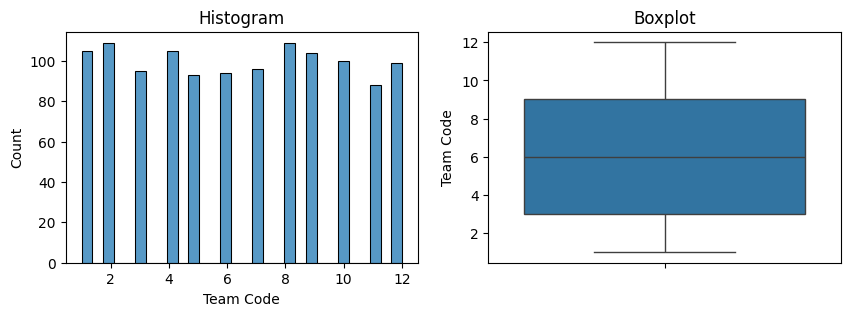

Skewness: 0.009847502796713321
Kurtosis: -1.2239057391150918


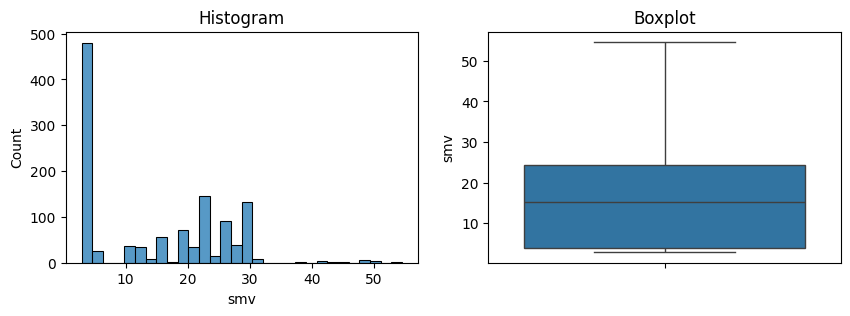

Skewness: 0.40593673685873205
Kurtosis: -0.7953459064328552


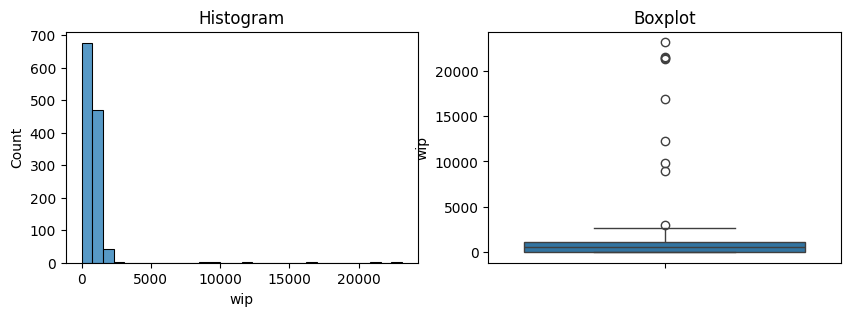

Skewness: 10.852386115117529
Kurtosis: 141.3326094754922


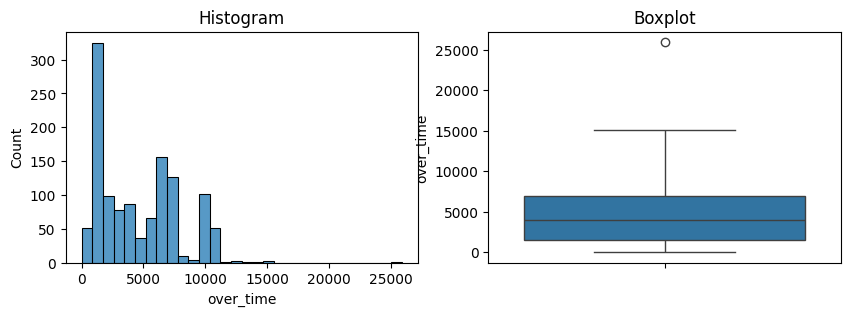

Skewness: 0.6732872952976457
Kurtosis: 0.4243642959188558


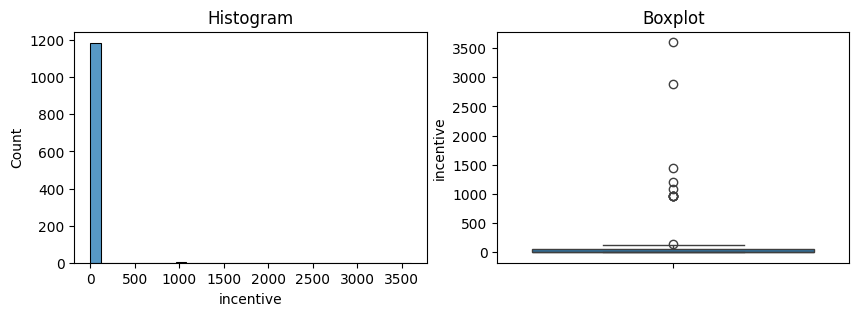

Skewness: 15.790746016958247
Kurtosis: 299.0324620996891


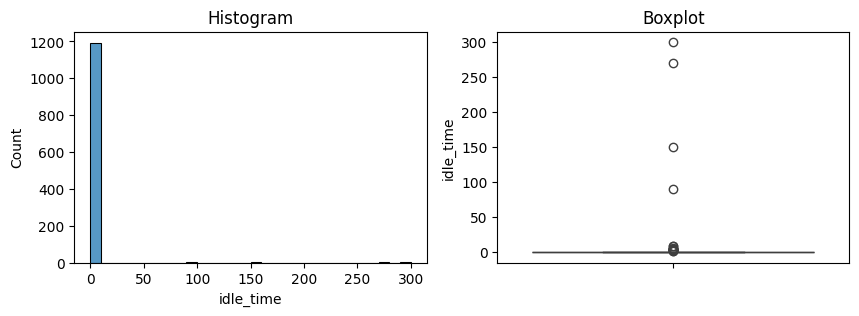

Skewness: 20.545425229670172
Kurtosis: 442.63816033937803


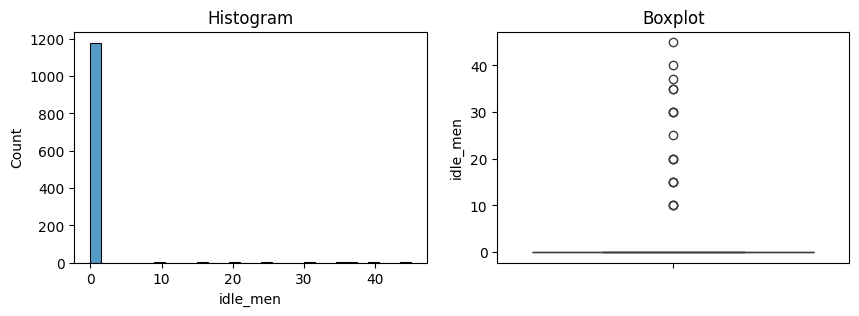

Skewness: 9.855079123524012
Kurtosis: 102.96286931944574


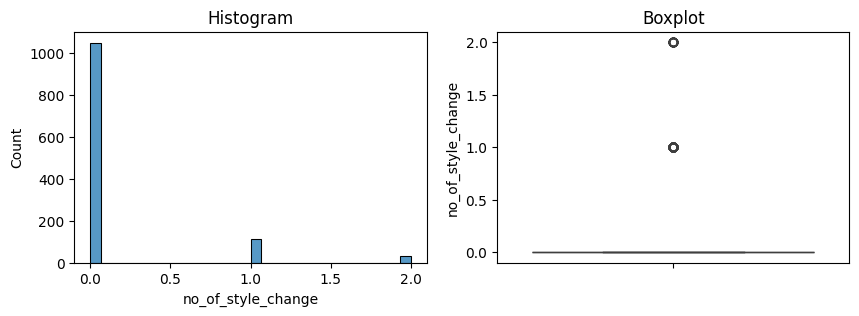

Skewness: 2.9425059460671514
Kurtosis: 8.18149032192787


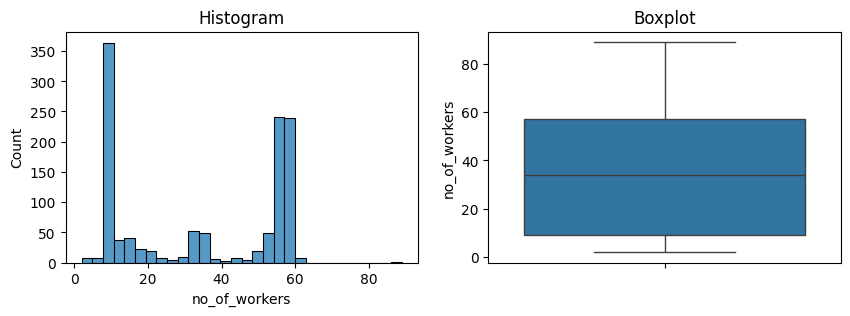

Skewness: -0.11173973121993644
Kurtosis: -1.7881079050779105


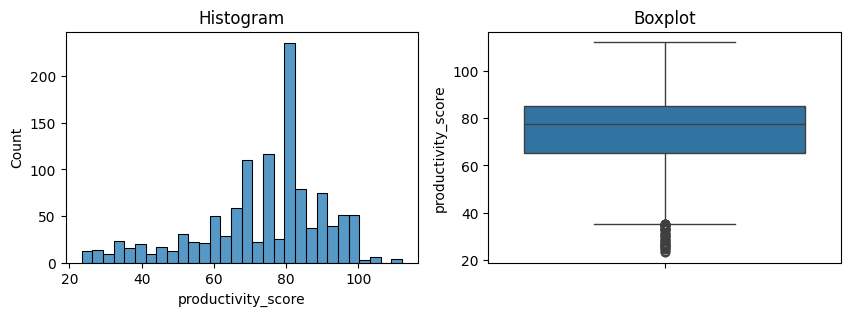

Skewness: -0.8065828586618801
Kurtosis: 0.3296986702964939


In [329]:
# Make a plot to check distribution
def check_distribution_outliers(df, columns):
    for i in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[i], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[i])
        plt.title('Boxplot')

        plt.show()

        print('Skewness:', df[i].skew())
        print('Kurtosis:', df[i].kurt())

check_distribution_outliers(df[numerical_columns], numerical_columns)

Based on the initial exploration, all columns in the dataset were found to be non-normally distributed, and several columns—such as **wip**, **over\_time**, **incentive**, **idle\_time**, **idle\_men**, **no\_of\_style\_change**, and **productivity\_score**—contain outliers. However, these outliers are still considered reasonable in the business context and do not indicate any clear data errors. Therefore, they were not removed but retained to preserve any potentially valuable information they may contain.

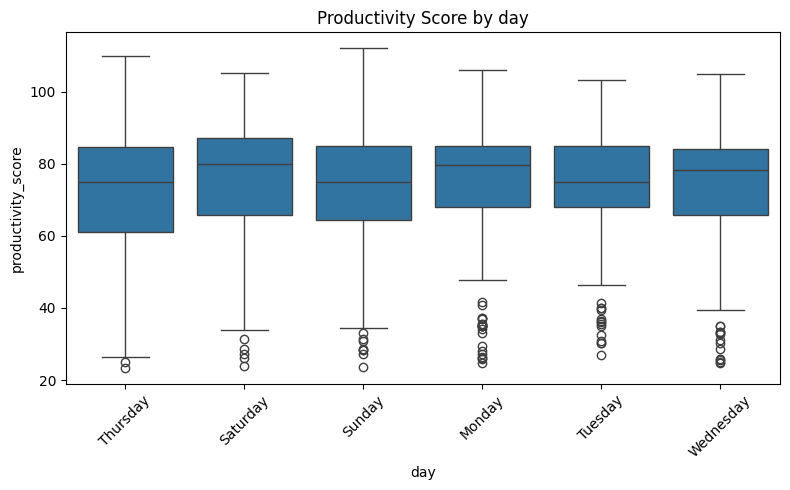

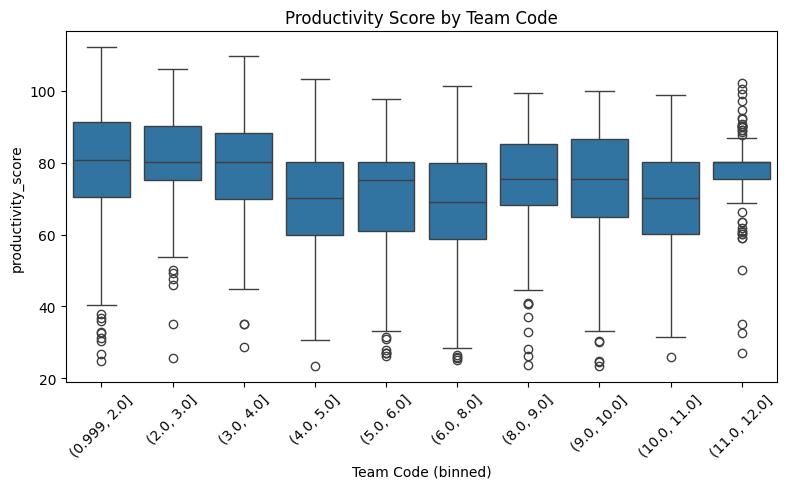

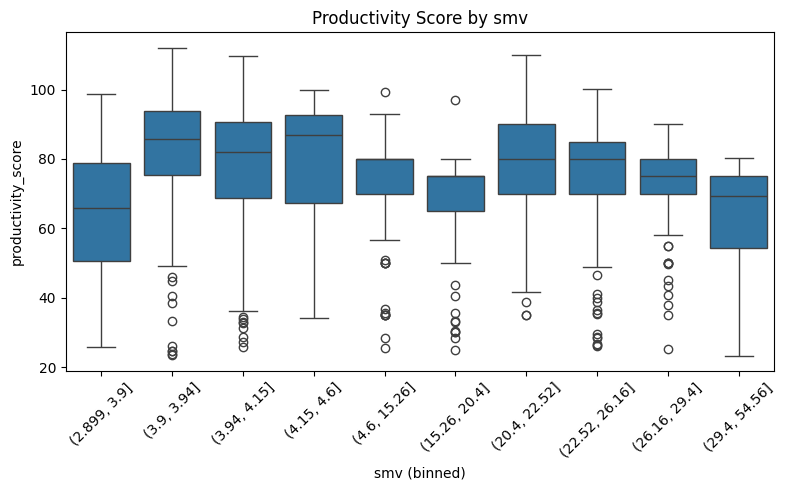

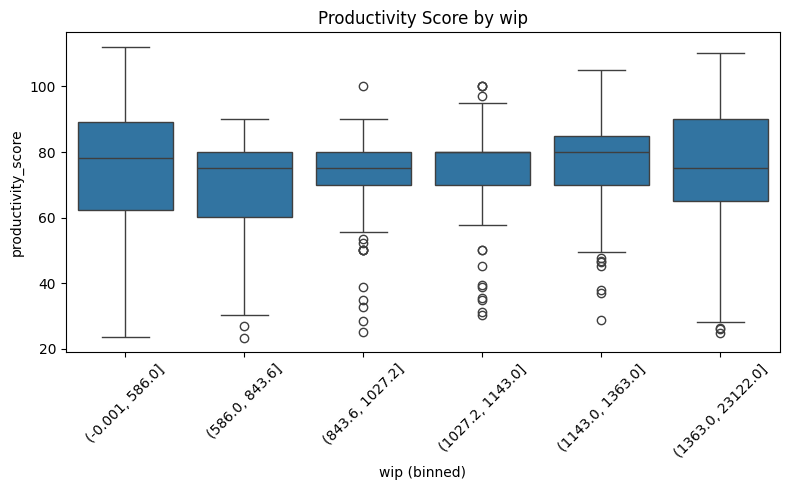

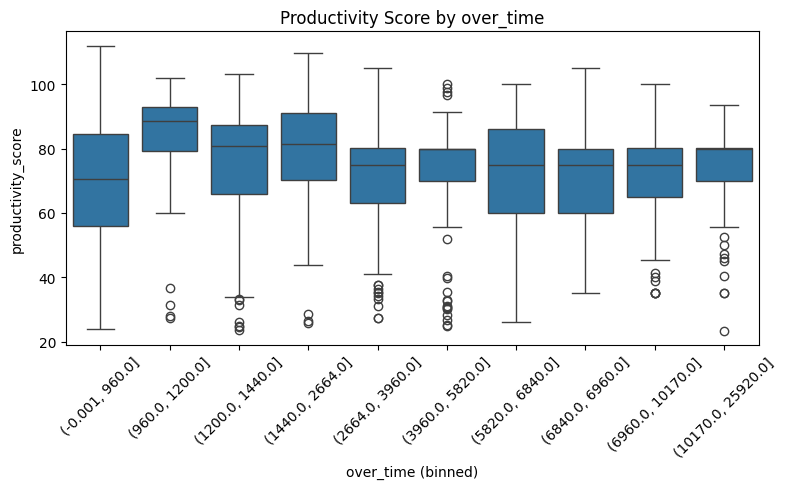

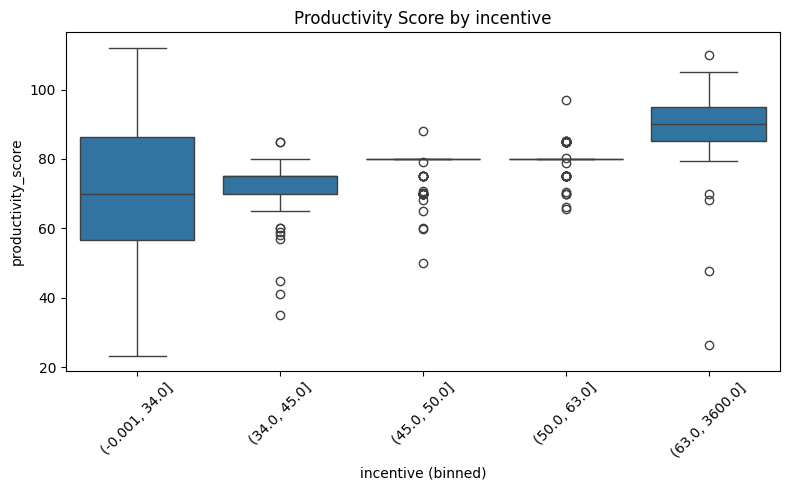

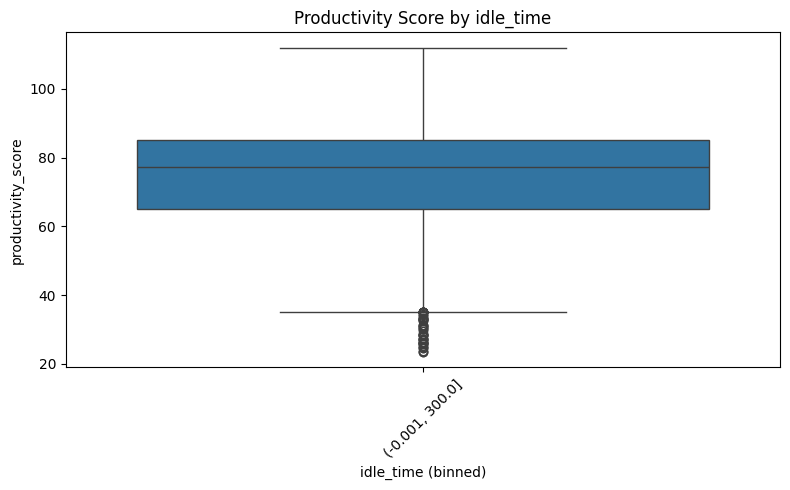

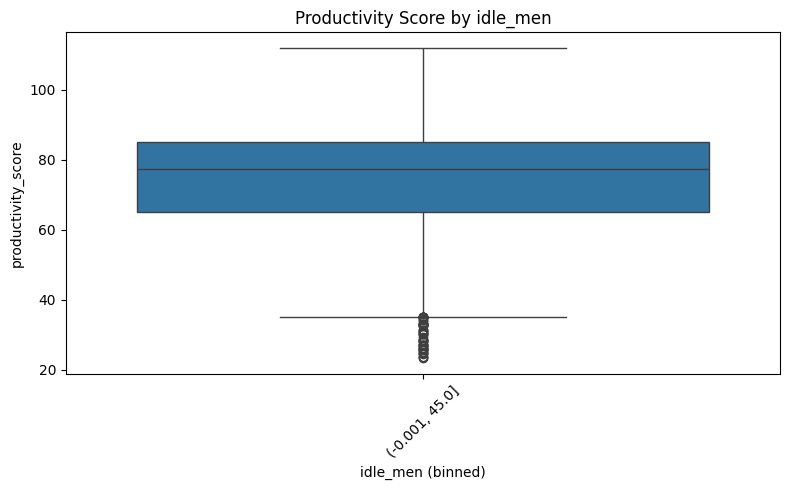

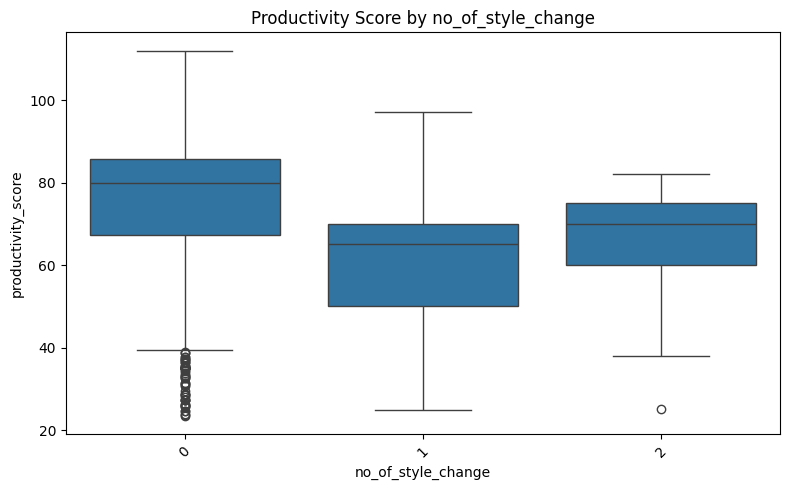

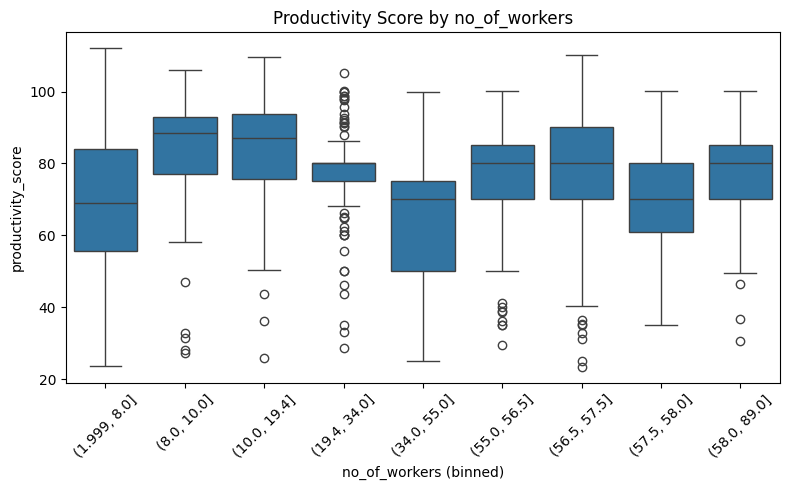

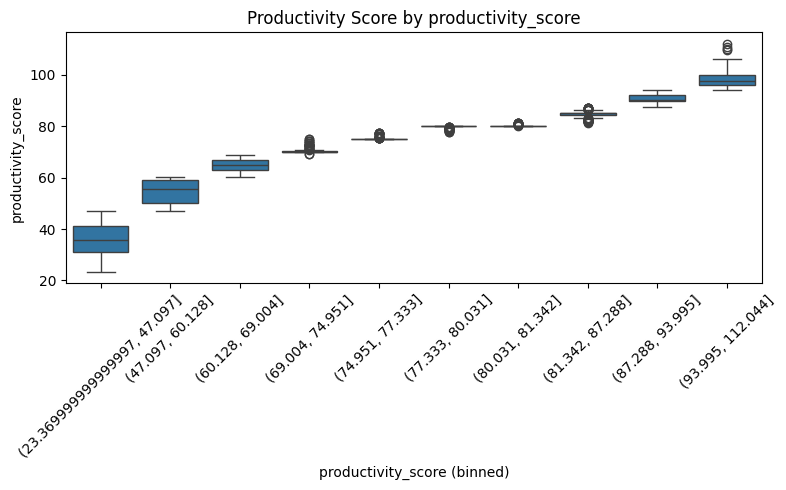

In [330]:
for col in df:
    if col == 'date':
        continue

    plt.figure(figsize=(8, 5))

    if df[col].dtype == 'object' or df[col].nunique() < 10:
        sns.boxplot(x=df[col], y=df['productivity_score'])
    else:
        try:
            df['binned'] = pd.qcut(df[col], q=10, duplicates='drop')
            sns.boxplot(x=df['binned'], y=df['productivity_score'])
            plt.xlabel(f'{col} (binned)')
            df.drop(columns='binned', inplace=True)
        except:
            print(f"Skipping column: {col} (qcut failed)")
            continue

    plt.title(f'Productivity Score by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Productivity Score by Day**

* Weekdays (Monday–Wednesday) tend to have slightly higher and more stable productivity.
* Weekends (Saturday & Sunday) show greater variation in productivity.

**Productivity Score by Team Code**

* Overall productivity scores are good, but some teams lag significantly behind.
* Teams with team codes 11–12 appear to be the most consistent and possibly the most productive.

**Productivity Score by SMV**

* Productivity scores tend to be higher when SMV is low, especially in the bins (3.9–4.15) and (3.94–4.15), with very high medians (\~90).
* Very high SMV values (e.g., 29.4–54.56) are associated with lower and more dispersed productivity scores.

**Productivity Score by WIP**

* The highest and most stable productivity occurs when WIP is low, especially in the bin (0.001–586.0), where the median is high and the distribution is solid.
* As WIP increases, the median productivity score drops, and more low outliers appear.
* Productivity rises again in the bins (1,143–1,363) and (1,363–23,122) but with large variation—indicating inconsistent performance.

**Productivity Score by Over Time**

* Moderate overtime may be optimal for maintaining or improving productivity.
* Too little or too much overtime can reduce productivity or cause inconsistency.

**Productivity Score by Incentive**

* Large incentives are effective in boosting and stabilizing productivity.
* Small to moderate incentives yield decent productivity but are not optimal.
* Without adequate incentives, productivity can become highly inconsistent and even low.

**Productivity Score by Idle Time**

* Some low-scoring individuals may be affected by poorly managed idle time (e.g., being idle, unfocused, or waiting for work).

**Productivity Score by Idle Men**

* Idle time among male employees does not show a significant overall negative effect on productivity.

**Productivity Score by Number of Style Changes**

* Employees who do not change their work style tend to be more productive.
* A single work style change may disrupt performance.
* More than one change slightly improves results—possibly due to better flexibility or successful trial and error.

**Productivity Score by Number of Workers**

* The optimal team size is between 8–20 workers, with the most stable and highest performance.
* Very small or very large teams tend to have more variation (less consistency) in performance.
* When the number of workers is too high (34–55), productivity drops significantly—likely due to organizational complexity.

# Feature Engineering

In [331]:
# Display the Data
df.head()

,date,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Thursday,1,3.94,0.0,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


## Split Date Column

In [332]:
df['date']= pd.to_datetime(df['date'], format='mixed')

I converted the data type of the **'date'** column from object to datetime to enable easier extraction of day, month, and year values. Since there were previously inconsistencies in the date format (using both slashes and dashes as separators), I applied the parameters `dayfirst=True` and `format='mixed'` during the conversion to automatically handle these differences. This step ensures that the date data can be processed consistently and accurately.

In [333]:
df['date_column'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

After converting the **'date'** column to datetime format, I split it into three separate columns: **'day'**, **'month'**, and **'year'**. The purpose of this separation is to simplify the modeling process in later stages, especially if time-related features such as month or year influence the target variable. By breaking down the date into its components, the model can more easily capture seasonal patterns or time-based trends.

In [334]:
# Drop Column 'date'
df.drop('date', axis=1, inplace=True)

In [335]:
# Rename 'date_column'
df.rename(columns={'date_column': 'date'}, inplace=True)

In [336]:
# Display the Data
df.head()

,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,date,month,year
0,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073,1,1,2015
1,Thursday,1,3.94,0.0,960,0,0.0,0,0,8.0,88.650,1,1,2015
2,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057,1,1,2015
3,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057,1,1,2015
4,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038,1,1,2015


## Encoding

In [338]:
# Encode 'day' column
day_map = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

df['day_encoded'] = df['day'].map(day_map)

In the encoding stage, I applied manual ordinal encoding to the **'day'** column. Since this column has an inherent order, ordinal encoding was considered the most appropriate method. I chose to perform the encoding manually rather than using a library because this approach allows me to define the order of values according to the data context. This method provides greater flexibility in handling ordinal categorical data.

In [339]:
df = pd.get_dummies(df, columns=['Team Code'], drop_first=True)

The **'team'** column needs to undergo encoding because its values are categorical and do not carry direct numerical meaning. Without encoding, the model would either treat the data as plain strings or ignore it entirely. By converting the categorical values into numerical form through encoding, the information in the **'team'** column can be effectively processed and interpreted by the model, thereby contributing more meaningfully to the training process.

In [340]:
df.head()

,day,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,...,Team Code_3,Team Code_4,Team Code_5,Team Code_6,Team Code_7,Team Code_8,Team Code_9,Team Code_10,Team Code_11,Team Code_12
0,Thursday,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073,...,False,False,False,False,False,True,False,False,False,False
1,Thursday,3.94,0.0,960,0,0.0,0,0,8.0,88.650,...,False,False,False,False,False,False,False,False,False,False
2,Thursday,11.41,968.0,3660,50,0.0,0,0,30.5,80.057,...,False,False,False,False,False,False,False,False,True,False
3,Thursday,11.41,968.0,3660,50,0.0,0,0,30.5,80.057,...,False,False,False,False,False,False,False,False,False,True
4,Thursday,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038,...,False,False,False,True,False,False,False,False,False,False


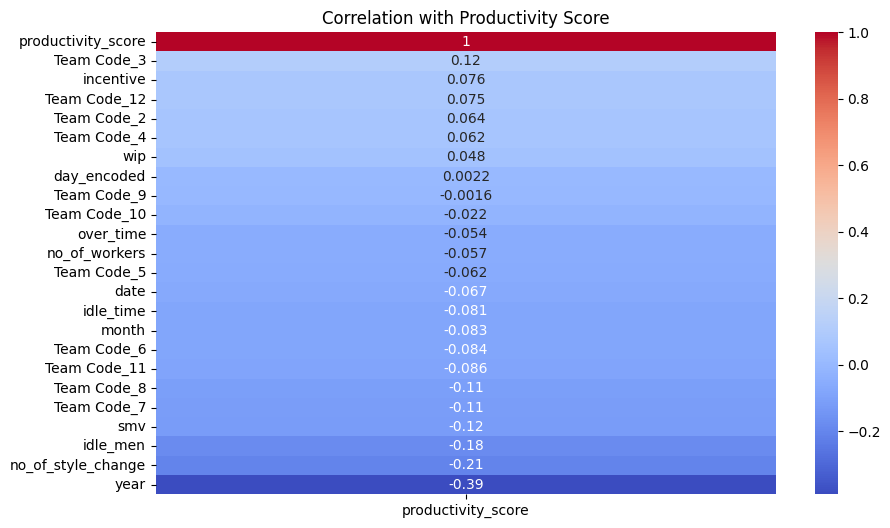

In [341]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True)[['productivity_score']].sort_values(by='productivity_score', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlation with Productivity Score')
plt.show()

Based on the correlation analysis, all columns in the dataset show a weak relationship with the **'productivity\_score'** variable. The highest correlation value is only **-0.39** from the **'year'** column, which is still considered a weak negative correlation. This indicates that no feature in the dataset has a strong linear relationship with productivity. Therefore, the model will likely need to rely on a combination of features or identify non-linear patterns in order to make accurate predictions.

In [ ]:
# Drop 'day' columns
df.drop('day', axis=1, inplace=True)

In [343]:
# Display the Data
df.head()

,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,date,...,Team Code_3,Team Code_4,Team Code_5,Team Code_6,Team Code_7,Team Code_8,Team Code_9,Team Code_10,Team Code_11,Team Code_12
0,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073,1,...,False,False,False,False,False,True,False,False,False,False
1,3.94,0.0,960,0,0.0,0,0,8.0,88.650,1,...,False,False,False,False,False,False,False,False,False,False
2,11.41,968.0,3660,50,0.0,0,0,30.5,80.057,1,...,False,False,False,False,False,False,False,False,True,False
3,11.41,968.0,3660,50,0.0,0,0,30.5,80.057,1,...,False,False,False,False,False,False,False,False,False,True
4,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038,1,...,False,False,False,True,False,False,False,False,False,False


# Data Splitting

In [344]:
x= df.drop('productivity_score', axis=1)
y= df['productivity_score']

In [345]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=2/3, random_state=42)

print("\nData shapes after splitting:")
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Validation: {x_val.shape}, {y_val.shape}")
print(f"Test: {x_test.shape}, {y_test.shape}\n")

print(f"Train: {len(x_train)/len(x):.1%}")
print(f"Validation: {len(x_val)/len(x):.1%}")
print(f"Test: {len(x_test)/len(x):.1%}")


Data shapes after splitting:
Train: (837, 23), (837,)
Validation: (120, 23), (120,)
Test: (240, 23), (240,)

Train: 69.9%
Validation: 10.0%
Test: 20.1%


## Scaling

In [347]:
from sklearn.preprocessing import RobustScaler

# Initialize Scalers
rob_scaler = RobustScaler()

# Scale the x train and x test
x_train = rob_scaler.fit_transform(x_train)
x_val = rob_scaler.fit_transform(x_val)
x_test = rob_scaler.transform(x_test)

I used **Robust Scaler** to normalize the data. This choice was based on observations of the numerical feature distributions, which showed that most columns did not follow a normal distribution and contained outliers. Robust Scaler applies scaling using the **median** and **interquartile range (IQR)**, making it more resistant to the influence of extreme values. As a result, the scaling process can preserve the key characteristics of the data without being distorted by outliers.

# Modelling

## Sequential Model

In [348]:
n= x_train.shape[1]

model = keras.Sequential([
    layers.Dense(2 * n, activation='relu', input_shape=(n,)),
    layers.Dense(4 * n, activation='relu'),
    layers.Dense(4 * n, activation='relu'),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [350]:
from tensorflow.keras.metrics import RootMeanSquaredError

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse', RootMeanSquaredError(name='rmse')]
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 46)             │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 92)             │         4,324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 92)             │         8,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            93 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,077 (54.99 KB)

 Trainable params: 14,077 (54.99 KB)

 Non-trainable params: 0 (0.00 B)

In [351]:
baseline_seq= model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 5438.4023 - mae: 71.3722 - mse: 5438.4023 - rmse: 73.7269 - val_loss: 4929.1187 - val_mae: 67.8344 - val_mse: 4929.1187 - val_rmse: 70.2077
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4899.5298 - mae: 66.9541 - mse: 4899.5298 - rmse: 69.9753 - val_loss: 3605.1694 - val_mae: 55.5728 - val_mse: 3605.1694 - val_rmse: 60.0431
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3738.9395 - mae: 52.6699 - mse: 3738.9395 - rmse: 60.6886 - val_loss: 1988.5570 - val_mae: 35.9662 - val_mse: 1988.5570 - val_rmse: 44.5932
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2032.4553 - mae: 34.1967 - mse: 2032.4553 - rmse: 44.8833 - val_loss: 1305.6229 - val_mae: 30.5963 - val_mse: 1305.6229 - val_rmse: 36.1334
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1242.3073 - mae: 26.6229 - mse: 1242.3073 - rmse: 35.1630 - val_loss: 748.6364 - val_mae: 22.0657 - val_mse: 748.6364 - val_rmse: 27.3612
Epoch

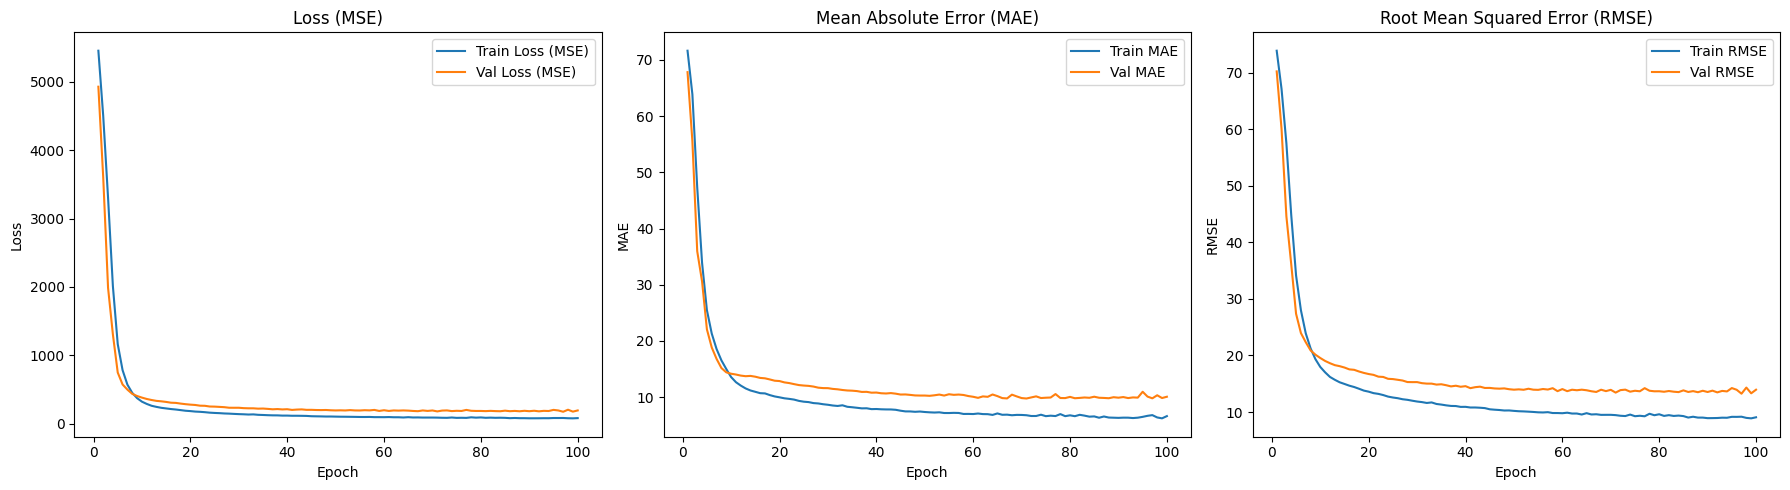

In [352]:
train_loss = baseline_seq.history['loss']
val_loss = baseline_seq.history['val_loss']
train_mae = baseline_seq.history['mae']
val_mae = baseline_seq.history['val_mae']
train_rmse = baseline_seq.history['rmse']
val_rmse = baseline_seq.history['val_rmse']
epochs = np.arange(1, len(train_loss) + 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MSE
axs[0].plot(epochs, train_loss, label='Train Loss (MSE)')
axs[0].plot(epochs, val_loss, label='Val Loss (MSE)')
axs[0].set_title('Loss (MSE)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# MAE
axs[1].plot(epochs, train_mae, label='Train MAE')
axs[1].plot(epochs, val_mae, label='Val MAE')
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].legend()

# RMSE
axs[2].plot(epochs, train_rmse, label='Train RMSE')
axs[2].plot(epochs, val_rmse, label='Val RMSE')
axs[2].set_title('Root Mean Squared Error (RMSE)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('RMSE')
axs[2].legend()

plt.tight_layout()
plt.show()


Based on the three evaluation metrics (**MSE**, **MAE**, and **RMSE**) it can be concluded that the **Baseline Sequential Model** is able to learn quite effectively. This is evident from the significant decrease in loss and error values during the early stages of training. Although there is a slight indication of overfitting, the difference is not substantial, as the gap between training and validation errors remains small. After around **20 to 30 epochs**, the learning process begins to stabilize, indicating that the model has reached a relatively steady performance level.

## Functional Model

In [353]:
def functional_model(n):
    inputs = tf.keras.Input(shape=(n,))
    x = layers.Dense(2 * n, activation='relu')(inputs)
    x = layers.Dense(4 * n, activation='relu')(x)
    x = layers.Dense(4 * n, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

func_model = functional_model(n)

In [354]:
func_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse', RootMeanSquaredError(name='rmse')]
)

func_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 46)             │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 92)             │         4,324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 92)             │         8,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            93 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,077 (54.99 KB)

 Trainable params: 14,077 (54.99 KB)

 Non-trainable params: 0 (0.00 B)

In [355]:
baseline_func= func_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5669.5879 - mae: 73.2101 - mse: 5669.5879 - rmse: 75.2888 - val_loss: 4921.4419 - val_mae: 67.7959 - val_mse: 4921.4419 - val_rmse: 70.1530
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4789.1631 - mae: 66.5503 - mse: 4789.1631 - rmse: 69.1901 - val_loss: 3412.9685 - val_mae: 54.9752 - val_mse: 3412.9685 - val_rmse: 58.4206
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3497.2109 - mae: 53.3233 - mse: 3497.2109 - rmse: 59.0669 - val_loss: 1897.4989 - val_mae: 38.5635 - val_mse: 1897.4989 - val_rmse: 43.5603
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1785.3101 - mae: 33.2701 - mse: 1785.3101 - rmse: 42.2266 - val_loss: 1054.1993 - val_mae: 26.8305 - val_mse: 1054.1993 - val_rmse: 32.4684
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 919.7008 - mae: 24.1971 - mse: 919.7008 - rmse: 30.2453 - val_loss: 794.9653 - val_mae: 23.2299 - val_mse: 794.9653 - val_rmse: 28.1951
Epoch 6

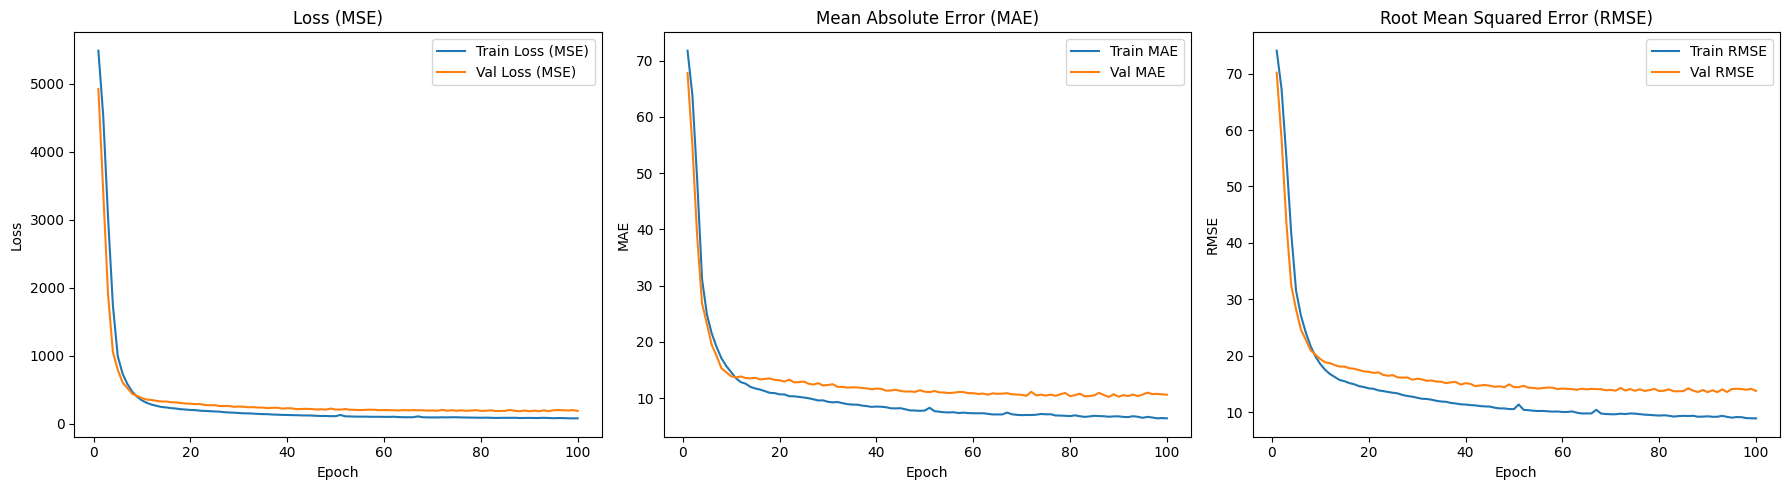

In [356]:
train_loss = baseline_func.history['loss']
val_loss = baseline_func.history['val_loss']
train_mae = baseline_func.history['mae']
val_mae = baseline_func.history['val_mae']
train_rmse = baseline_func.history['rmse']
val_rmse = baseline_func.history['val_rmse']
epochs = np.arange(1, len(train_loss) + 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MSE
axs[0].plot(epochs, train_loss, label='Train Loss (MSE)')
axs[0].plot(epochs, val_loss, label='Val Loss (MSE)')
axs[0].set_title('Loss (MSE)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# MAE
axs[1].plot(epochs, train_mae, label='Train MAE')
axs[1].plot(epochs, val_mae, label='Val MAE')
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].legend()

# RMSE
axs[2].plot(epochs, train_rmse, label='Train RMSE')
axs[2].plot(epochs, val_rmse, label='Val RMSE')
axs[2].set_title('Root Mean Squared Error (RMSE)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('RMSE')
axs[2].legend()

plt.tight_layout()
plt.show()

Based on the three evaluation graphs (**MSE**, **MAE**, and **RMSE**) it can be concluded that the **Baseline Functional Model** is able to learn quite well. This is evident from the significant decrease in loss and error values during the early stages of training. However, around **epoch 40**, signs of **overfitting** begin to appear, indicated by the *validation loss* starting to stagnate and slightly increase, particularly in the MSE graph. This pattern suggests that the model’s learning process is beginning to lose its optimal generalization capability.

# Modified Model

## Sequential Model

In [357]:
from tensorflow.keras import layers, callbacks

n = x_train.shape[1]

modified_model = keras.Sequential([
    layers.Dense(n * 2, activation='relu', input_shape=(n,)),
    # layers.Dropout(0.2),
    layers.Dense(n * 4, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(n * 4, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(n * 2 , activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [358]:
modified_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse', RootMeanSquaredError(name='rmse')]
)

modified_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 46)             │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 92)             │         4,324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 92)             │         8,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 46)             │         4,278 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            47 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,309 (71.52 KB)

 Trainable params: 18,309 (71.52 KB)

 Non-trainable params: 0 (0.00 B)

In [359]:
callbacks_model = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

In [360]:
modified_sequential = modified_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks= callbacks_model ,
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5589.6787 - mae: 72.7292 - mse: 5589.6787 - rmse: 74.7612 - val_loss: 4778.8672 - val_mae: 66.7434 - val_mse: 4778.8672 - val_rmse: 69.1293 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4586.6201 - mae: 63.0811 - mse: 4586.6201 - rmse: 67.7088 - val_loss: 3290.8333 - val_mae: 52.1412 - val_mse: 3290.8333 - val_rmse: 57.3658 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3087.9927 - mae: 47.6777 - mse: 3087.9927 - rmse: 55.5385 - val_loss: 1930.2299 - val_mae: 37.3406 - val_mse: 1930.2299 - val_rmse: 43.9344 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1809.7803 - mae: 33.9100 - mse: 1809.7803 - rmse: 42.5126 - val_loss: 1062.7456 - val_mae: 27.5836 - val_mse: 1062.7456 - val_rmse: 32.5998 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1067.3522 - mae: 25.5464 - mse: 1067.3522 - rmse

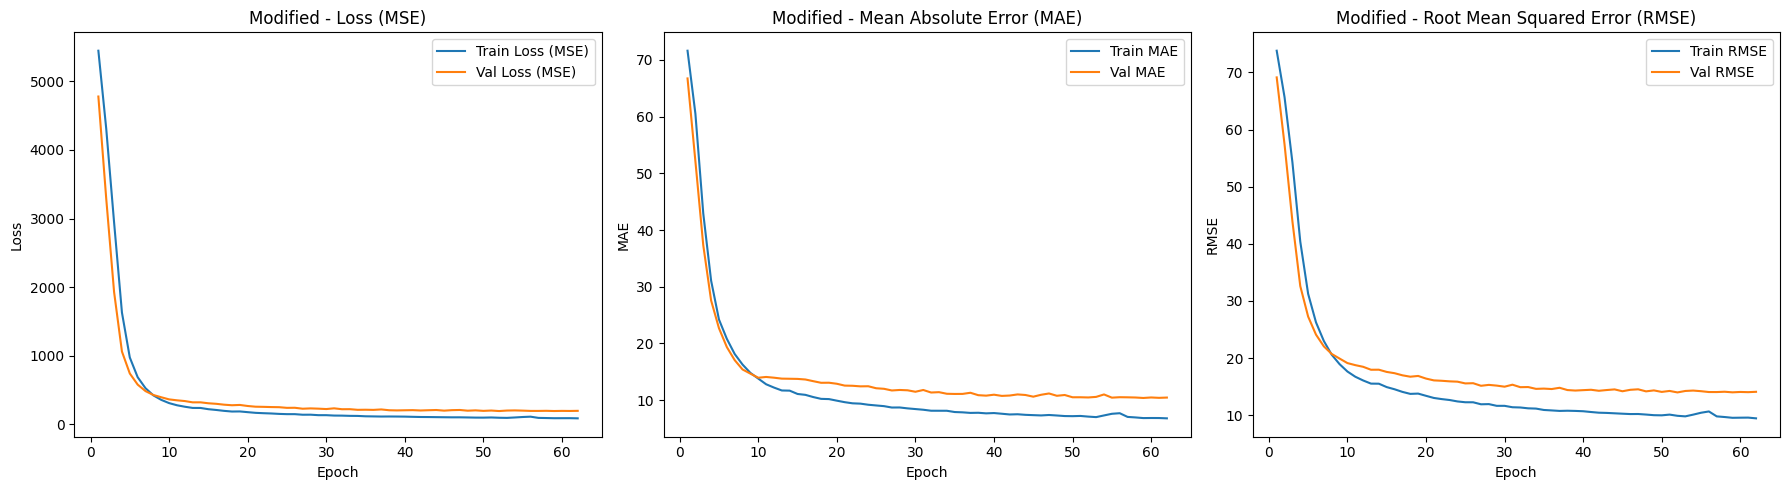

In [361]:
train_loss = modified_sequential.history['loss']
val_loss = modified_sequential.history['val_loss']
train_mae = modified_sequential.history['mae']
val_mae = modified_sequential.history['val_mae']
train_rmse = modified_sequential.history['rmse']
val_rmse = modified_sequential.history['val_rmse']
epochs = np.arange(1, len(train_loss) + 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MSE
axs[0].plot(epochs, train_loss, label='Train Loss (MSE)')
axs[0].plot(epochs, val_loss, label='Val Loss (MSE)')
axs[0].set_title('Modified - Loss (MSE)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# MAE
axs[1].plot(epochs, train_mae, label='Train MAE')
axs[1].plot(epochs, val_mae, label='Val MAE')
axs[1].set_title('Modified - Mean Absolute Error (MAE)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].legend()

# RMSE
axs[2].plot(epochs, train_rmse, label='Train RMSE')
axs[2].plot(epochs, val_rmse, label='Val RMSE')
axs[2].set_title('Modified - Root Mean Squared Error (RMSE)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('RMSE')
axs[2].legend()

plt.tight_layout()
plt.show()

The **Modified Baseline Model** demonstrates more stable and generalizable performance compared to the initial model. This is reflected in the reduced signs of overfitting, lower validation error values, and more consistent and smoother evaluation metric patterns throughout the training process.

## Functional Model

In [362]:
from tensorflow.keras.models import Model

def model_builder(hp):
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

  inputs = tf.keras.Input(shape=(n, ))
  dense1 = layers.Dense(units=hp_units, activation="relu")(inputs)
  dense2 = layers.Dense(units=hp_units,activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_initializer=tf.keras.initializers.GlorotUniform())(dense1)
  cat_layer = tf.keras.layers.Concatenate(axis=1)([dense1,dense2])
  out = layers.Dense(1,activation='linear')(cat_layer)

  model = Model(inputs=inputs, outputs=out)

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

  return model

In [363]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='exp',
                     project_name='kt')

Reloading Tuner from exp/kt/tuner0.json


In [365]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(x_train,y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [366]:
best_hps.values

{'units': 480,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0013'}

In [367]:
n = 23

def tuned_functional_model(n, learning_rate=0.01):
    inputs = tf.keras.Input(shape=(n,))
    x = layers.Dense(2 * n, activation='relu')(inputs)  # 46 units
    x = layers.Dense(4 * n, activation='relu')(x)       # 92 units
    x = layers.Dense(4 * n, activation='relu')(x)       # 92 units
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', 'mse', RootMeanSquaredError(name='rmse')])
    return model

tuned_func_model = tuned_functional_model(n=23, learning_rate=0.01)
tuned_func_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 46)             │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 92)             │         4,324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 92)             │         8,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │            93 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,077 (54.99 KB)

 Trainable params: 14,077 (54.99 KB)

 Non-trainable params: 0 (0.00 B)

In [368]:
tuned_model = tuned_func_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks_model,
    verbose=1
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4138.4321 - mae: 51.8860 - mse: 4138.4321 - rmse: 64.1812 - val_loss: 1526.6005 - val_mae: 29.9733 - val_mse: 1526.6005 - val_rmse: 39.0717 - learning_rate: 0.0100
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1902.2106 - mae: 29.5872 - mse: 1902.2106 - rmse: 42.1501 - val_loss: 482.2861 - val_mae: 16.3824 - val_mse: 482.2861 - val_rmse: 21.9610 - learning_rate: 0.0100
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 376.3909 - mae: 15.1290 - mse: 376.3909 - rmse: 19.3809 - val_loss: 372.1443 - val_mae: 14.9112 - val_mse: 372.1443 - val_rmse: 19.2910 - learning_rate: 0.0100
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 278.1107 - mae: 12.6359 - mse: 278.1107 - rmse: 16.6372 - val_loss: 360.9584 - val_mae: 15.0294 - val_mse: 360.9584 - val_rmse: 18.9989 - learning_rate: 0.0100
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 263.3788 - mae: 12.3884 - mse: 263.3788 - rmse: 16.2219 - val_

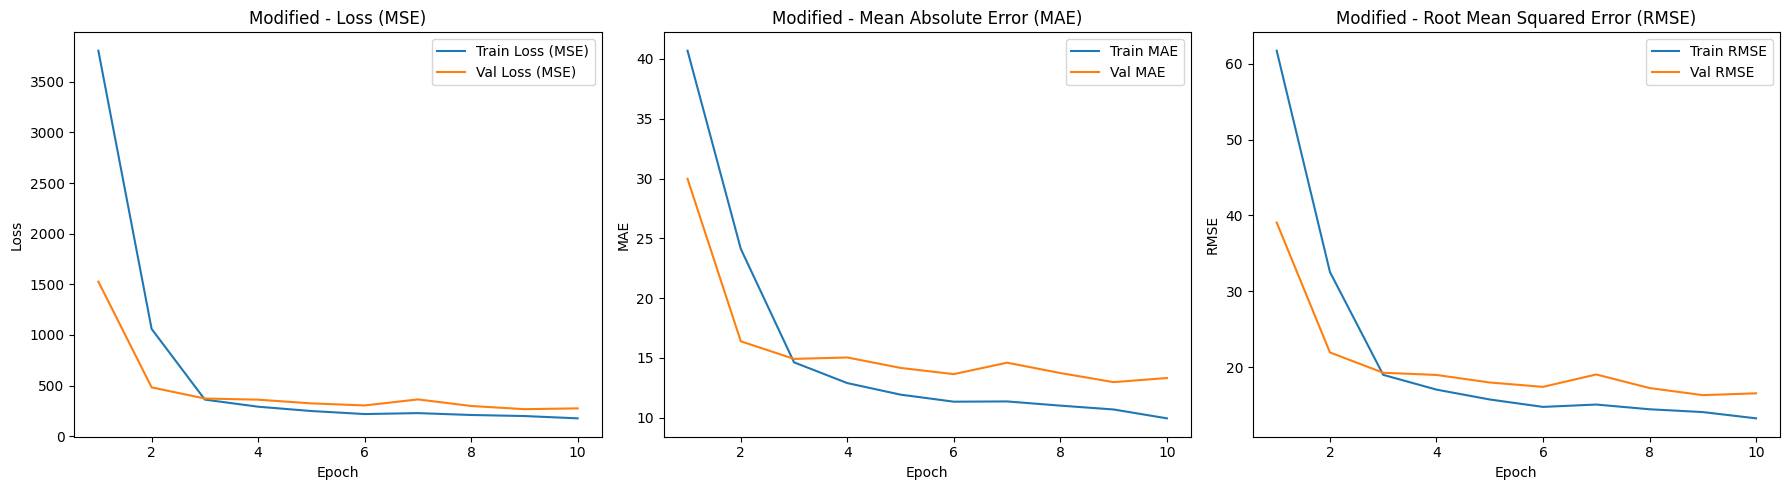

In [372]:
train_loss = tuned_model.history['loss']
val_loss = tuned_model.history['val_loss']
train_mae = tuned_model.history['mae']
val_mae = tuned_model.history['val_mae']
train_rmse = tuned_model.history['rmse']
val_rmse = tuned_model.history['val_rmse']
epochs = np.arange(1, len(train_loss) + 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MSE
axs[0].plot(epochs, train_loss, label='Train Loss (MSE)')
axs[0].plot(epochs, val_loss, label='Val Loss (MSE)')
axs[0].set_title('Modified - Loss (MSE)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# MAE
axs[1].plot(epochs, train_mae, label='Train MAE')
axs[1].plot(epochs, val_mae, label='Val MAE')
axs[1].set_title('Modified - Mean Absolute Error (MAE)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].legend()

# RMSE
axs[2].plot(epochs, train_rmse, label='Train RMSE')
axs[2].plot(epochs, val_rmse, label='Val RMSE')
axs[2].set_title('Modified - Root Mean Squared Error (RMSE)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('RMSE')
axs[2].legend()

plt.tight_layout()
plt.show()

Compared to the **Baseline Functional Model**, this model exhibits less optimal learning performance. This is evident from the decreases in MSE, MAE, and RMSE, which are neither as significant nor as smooth as those observed in the Baseline Model. The inconsistent decline pattern indicates that the model’s learning process has not been running effectively.

# Evaluation

In [373]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

def compare_models(models, X_test, y_test):
    results = []

    for name, model in models.items():
        y_pred = model.predict(x_test).flatten()
        mae, mse, rmse, r2 = regression_report(y_test, y_pred)
        results.append({
            'Model': name,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })

    df = pd.DataFrame(results)
    return df


In [374]:
models = {
    'Sequential': model,
    'Functional': func_model,
    'Modified Sequential': modified_model,
    'Modified Functional': tuned_func_model
}

comparison_df = compare_models(models, x_test, y_test)
print(comparison_df)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                 Model        MAE         MSE       RMSE        R2
0           Sequential   8.098601  137.419288  11.722597  0.515958
1           Functional   8.555831  148.231448  12.175034  0.477874
2  Modified Sequential   8.112606  131.586483  11.471115  0.536504
3  Modified Functional  11.034802  190.110382  13.788052  0.330361


**MAE**

MAE represents the average absolute difference between the predictions and the actual values. The smaller the MAE, the better the model’s performance. Based on the evaluation of the four models, the **Sequential Model** achieved the lowest MAE, while the **Modified Functional** model had the highest.

**MSE**

MSE is highly sensitive to outliers because it involves squaring the errors. The smaller the MSE, the better the model. The **Modified Sequential** model achieved the best MSE score, while the **Modified Functional** model performed the worst.

**RMSE**

RMSE measures the average difference between predicted and actual values, expressed in the same units as the target variable. The **Modified Sequential** model obtained the lowest RMSE, whereas the **Modified Functional** model had the highest.

**R²**

R² indicates how well the model explains the variance in the data. The closer the value is to 1, the better the model. Among the four models, the **Modified Sequential** model had the highest R² score, while the **Modified Functional** model had the lowest.

**Conclusion**

**Best Performer: Modified Sequential**
It outperformed all other models across all key metrics (MAE, MSE, RMSE, R²). This suggests that the architectural modifications applied to the sequential model significantly improved its accuracy.

**Weakest Model: Modified Functional**
The modifications applied to the functional model reduced its performance compared to its original version. R² dropped significantly (from 0.478 to 0.330), and both MAE and RMSE worsened.